In [179]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [180]:
from skbio.stats import composition
import numpy as np


def clr(counts_data,log= np.log):


    #TODO: check if count data

    # remove columns with all
    data= counts_data.loc[:,~(counts_data<=1).all()]

    #dataframe with replace zeros
    data= pd.DataFrame( composition.multiplicative_replacement(data),
                       columns=data.columns,
                       index= data.index
                      )

    data= log(data)
    data = (data.T-data.mean(1)).T

    return data



In [181]:
concat = pd.DataFrame()
for file in glob("metadata_sources/MetaPhlAn/2021*.tsv"):
    loaded_df = pd.read_csv(file, sep = '\t', index_col=0, low_memory=False).transpose()
    concat = pd.concat([concat,loaded_df], join = "outer")

In [182]:
list_of_species = []
other_list = []
for i in concat.columns:
    if i.startswith("k_"):
        list_of_species.append(i)
    else:
        other_list.append(i)
len(list_of_species)

2040

In [183]:
filled_df = concat.fillna(value=0)
for species in list_of_species:
    filled_df[species] = pd.to_numeric(filled_df[species])

In [184]:
healthy_samples = filled_df[filled_df['disease']=="healthy"]
temperatures = pd.DataFrame()
temperatures["country"] = healthy_samples.country.value_counts().index
temperatures["temperature"] = [14.9,11.8,13,25,13,10.7,5.8,6.3,17.4,26,15.3,-0.1,12.4,-0.6,3.8,29.6,6.4,27.75,26.55,12.7,24.25,19.4,26.35,-1.35,8.95,18.7,14.9,17,28.35,11.1,27.2,24.95,10.4,30.3,30.6,29.6,26.6,4.6]
healthy_with_temp = healthy_samples.merge(temperatures, on = "country")

In [185]:
healthy_with_temp = healthy_with_temp[healthy_with_temp['body_site']=="stool"]
adult_df = healthy_with_temp[healthy_with_temp["age_category"]=="adult"]
adult_non_west = adult_df[adult_df["non_westernized"]=="no"]

In [186]:
list_of_species_adult = []
for i in adult_non_west.columns:
    if i.startswith("k__"):
        list_of_species_adult.append(i)

In [187]:
only_species = pd.DataFrame()
for species in list_of_species_adult:
    only_species = pd.concat([only_species,adult_non_west[species]], axis =1)

In [188]:
clr_species = clr(only_species)

In [189]:
clr_transformed_with_temp = pd.concat([pd.DataFrame(clr_species),adult_non_west["temperature"]],axis =1).reset_index(drop=True)

Text(0.5, 1.0, 'Correlation between average temperatures (in C) and their MetaPhLan profiles.\nCountries are aggregated by taking mean abundance per species for all samples from that country.\nCorrelation between profiles is pearson')

<Figure size 2160x1800 with 0 Axes>

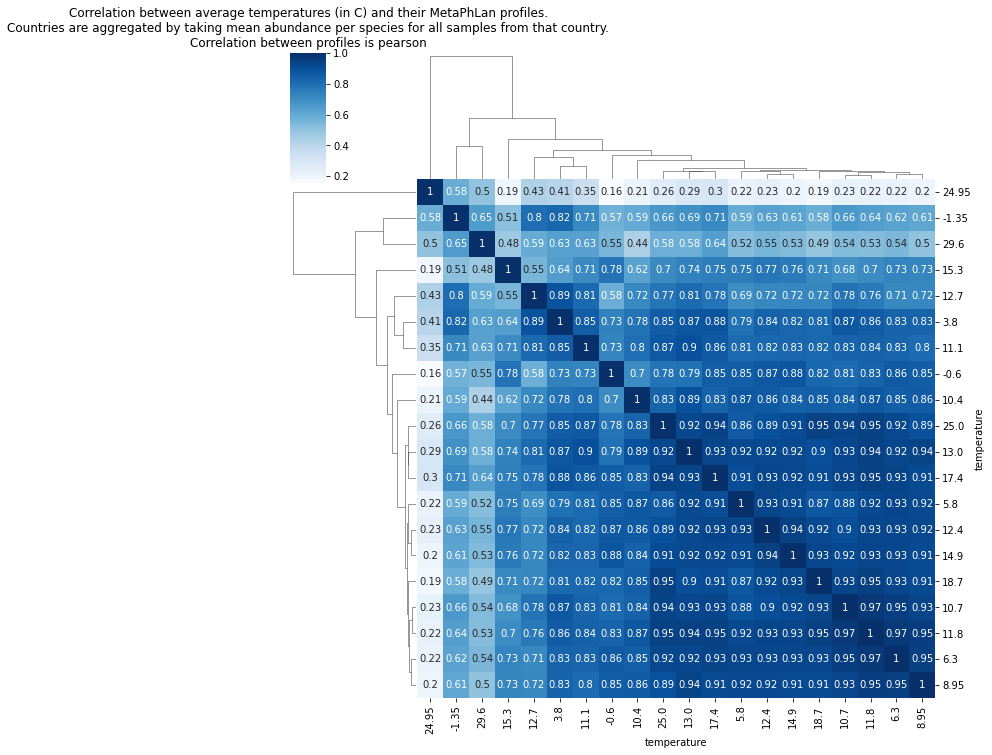

In [190]:
general_corr = clr_transformed_with_temp.groupby("temperature").median().transpose()
fig = plt.figure(figsize=(30,25))
heatmap = sns.clustermap(general_corr.corr(method='pearson'), annot = True, cmap="Blues")
plt.title("Correlation between average temperatures (in C) and their MetaPhLan profiles.\n"
          "Countries are aggregated by taking mean abundance per species for all samples from that country.\n"
          "Correlation between profiles is pearson")

Text(0.5, 1.0, 'Correlation between average temperatures (in C) and their MetaPhLan profiles, after dropping BGD (24.95C).\nCountries are aggregated by taking mean abundance per species for all samples from that country.\nCorrelation between profiles is spearman')

<Figure size 2160x1800 with 0 Axes>

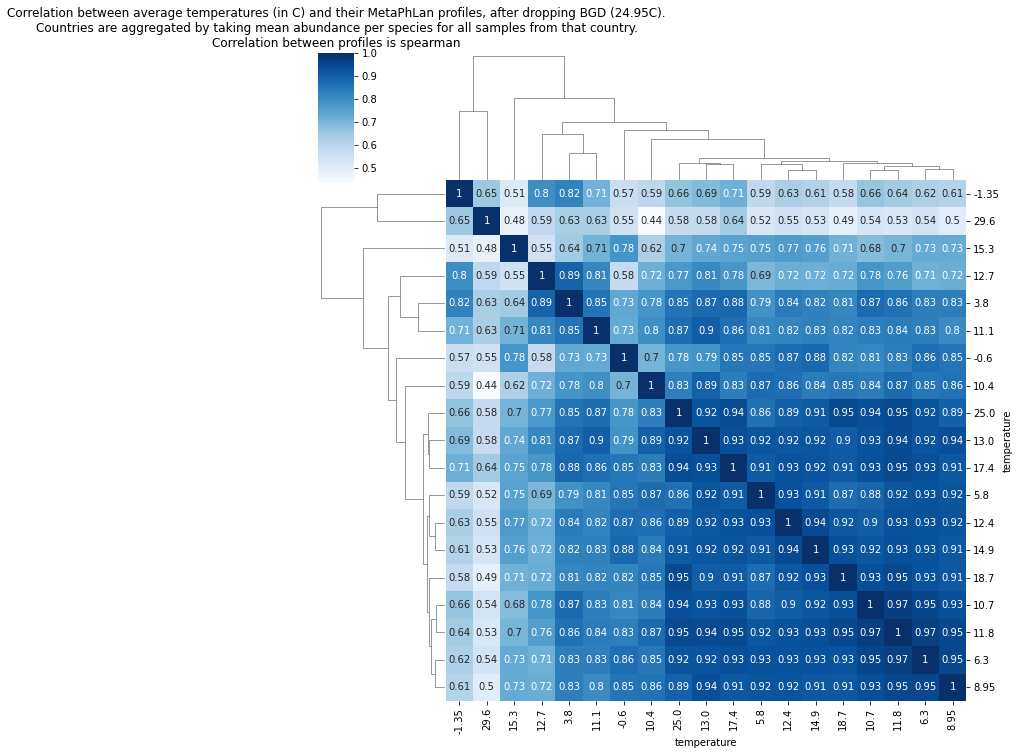

In [191]:
#Dropping country corresponding to 24.95C - something is different about it (outlier)
clr_transformed_with_temp = clr_transformed_with_temp[clr_transformed_with_temp["temperature"]!=24.95]
general_corr = clr_transformed_with_temp.groupby("temperature").median().transpose()
fig = plt.figure(figsize=(30,25))
heatmap = sns.clustermap(general_corr.corr(method='pearson'), annot = True, cmap="Blues")
plt.title("Correlation between average temperatures (in C) and their MetaPhLan profiles, after dropping BGD (24.95C).\n"
          "Countries are aggregated by taking mean abundance per species for all samples from that country.\n"
          "Correlation between profiles is spearman")

In [206]:
genus_dict = {}
for species in clr_transformed_with_temp.columns.drop('temperature'):
    genus = "|".join(species.split("|")[:-1])
    genus = "".join(genus.split("|")[-1])
    genus = "".join(genus.split("__")).lstrip("g")
    genus_dict[species] = genus
genus_df = dataframe_per_species.rename(genus_dict, axis = 1)
genus_df = genus_df.groupby(level=0, axis=1).sum()

In [207]:
genus_df = genus_df.reset_index()
final_df_clr_genus = pd.DataFrame()
for genus in genus_df.columns.drop('temperature'):
    final_df_clr_genus = pd.concat([final_df_clr_genus,pd.DataFrame(genus_df.groupby("temperature").median()[genus])], axis =1)

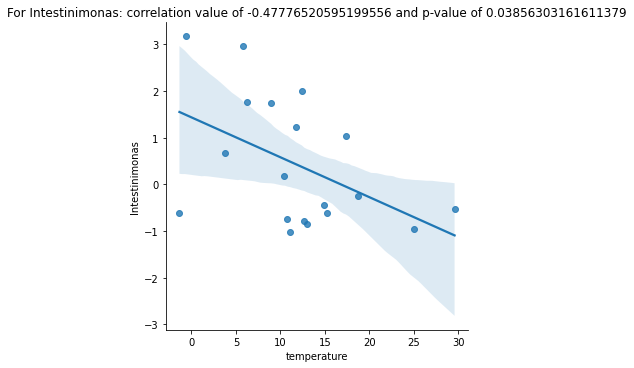

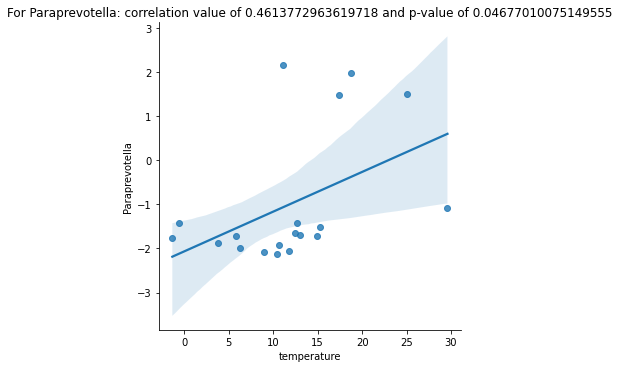

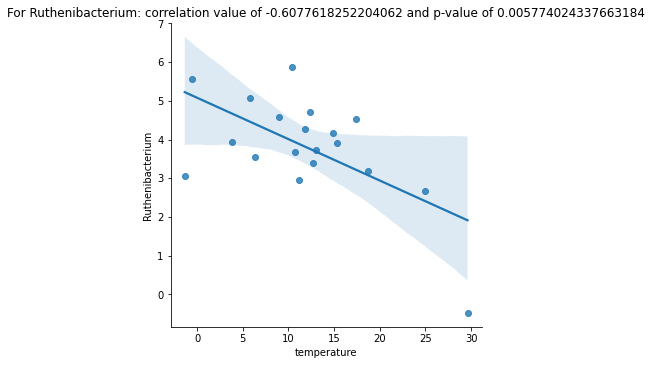

In [209]:
final_df_clr_genus = final_df_clr_genus.reset_index()
for genus in final_df_clr_genus.columns.drop('temperature'):
    r, p = stats.pearsonr(final_df_clr_genus["temperature"],final_df_clr_genus[genus])
    if p < 0.05 and abs(r) > 0.3:
        sns.lmplot(x="temperature", y = genus, data = final_df_clr_genus)
        plt.title(f"For {genus}: correlation value of {r} and p-value of {p}")

In [210]:
dataframe_per_species = pd.DataFrame()
for species in clr_species:
    dataframe_per_species = pd.concat([dataframe_per_species,pd.DataFrame(clr_transformed_with_temp.groupby("temperature").median()[species])], axis =1)

In [211]:
clr_species = []
for i in clr_transformed_with_temp.columns:
    if i.startswith("k__"):
        clr_species.append(i)

In [212]:
dataframe_per_species = dataframe_per_species.reset_index()

In [213]:
for species in dataframe_per_species.columns:
    dataframe_per_species[species] = pd.to_numeric(dataframe_per_species[species])

In [214]:
dictionary_of_species = {}
for species in dataframe_per_species.columns:
    new_name = "".join(species.split("|")[-1])
    new_name = "".join(new_name.split("__")).lstrip("s")
    dictionary_of_species[species] = new_name

In [215]:
dataframe_per_species = dataframe_per_species.rename(dictionary_of_species,axis=1)

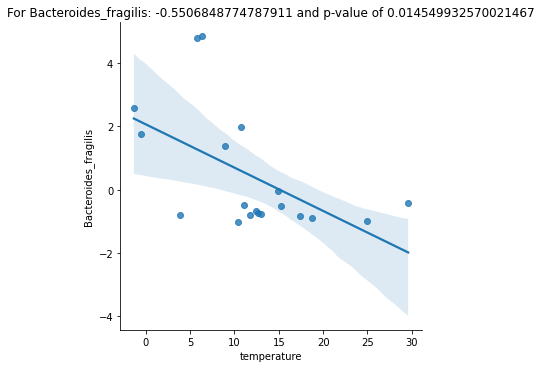

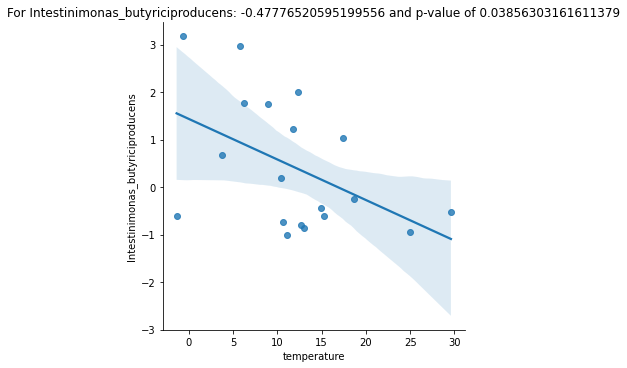

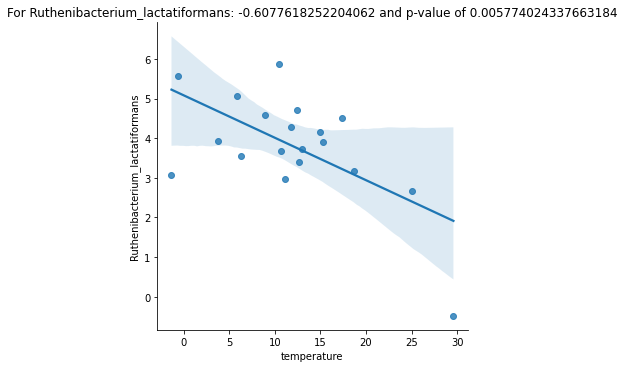

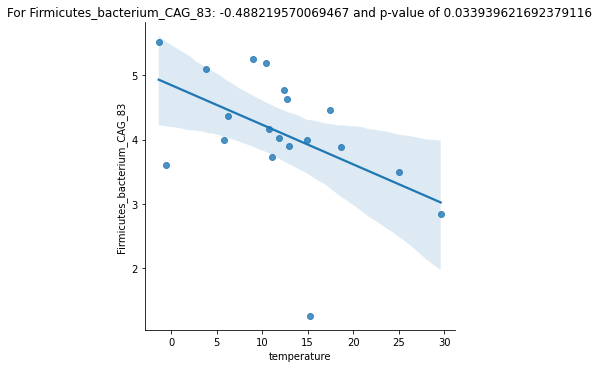

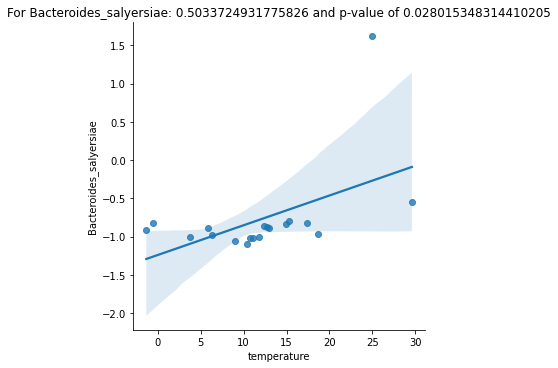

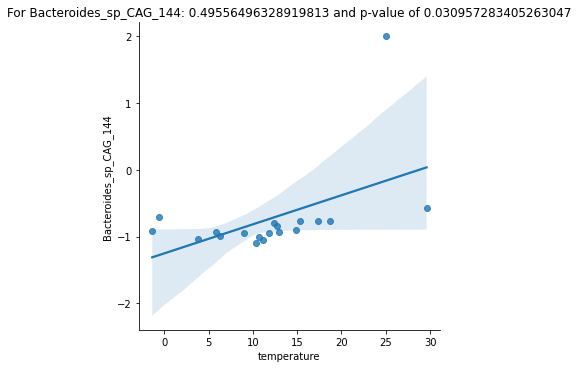

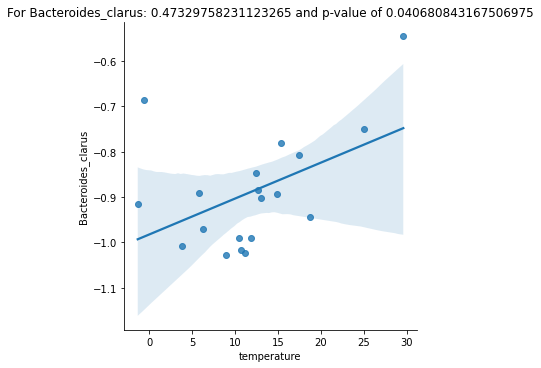

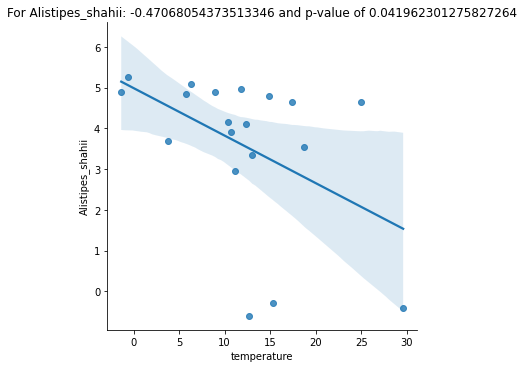

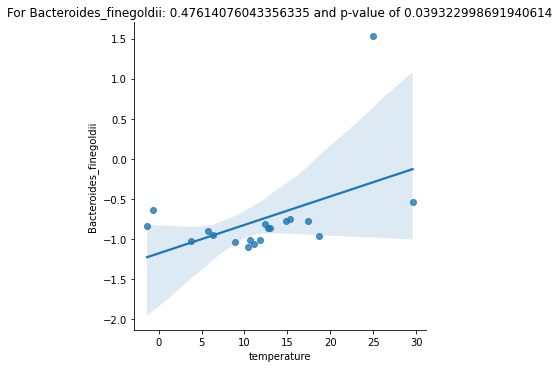

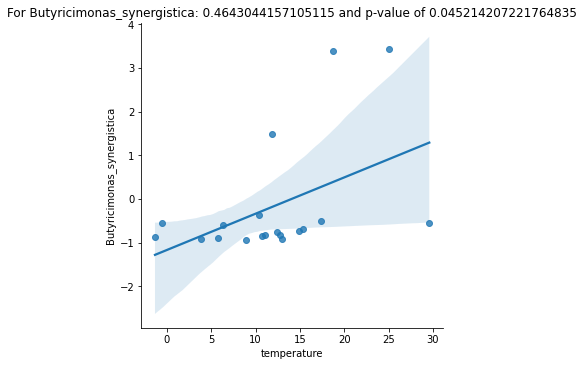

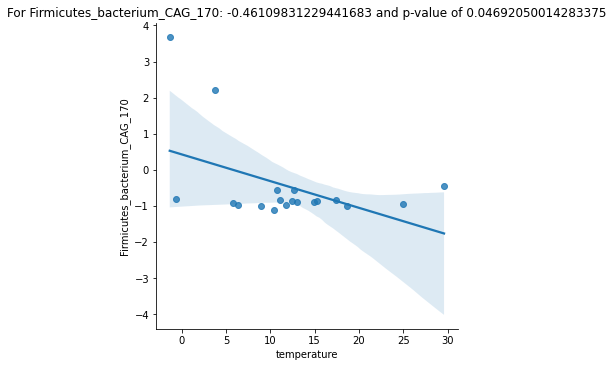

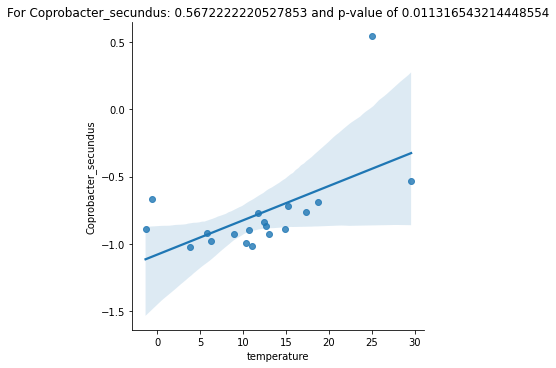

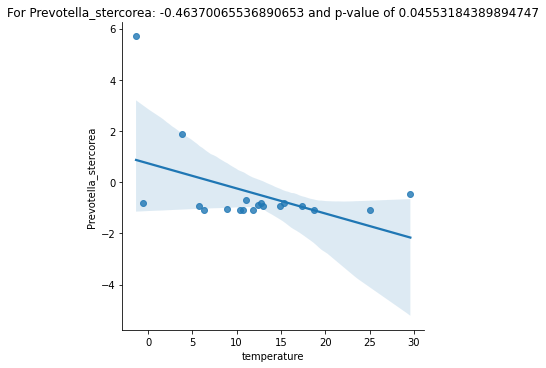

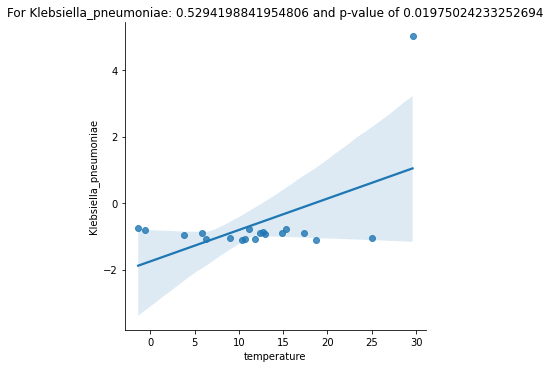

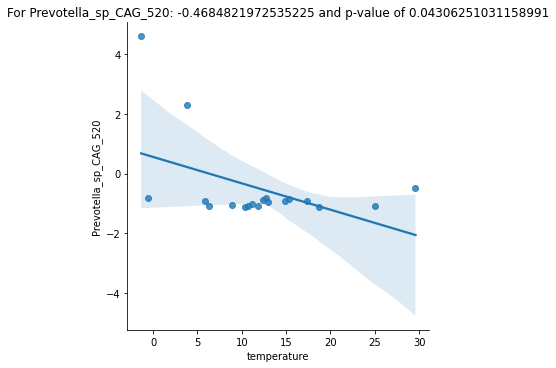

In [216]:
for species in dataframe_per_species.columns.drop('temperature'):
    r, p = stats.pearsonr(dataframe_per_species['temperature'], dataframe_per_species[species])
    if abs(r) > 0.3 and p < 0.05:
        sns.lmplot(x='temperature', y = species, data = dataframe_per_species)
        plt.title(f"For {species}: {r} and p-value of {p}")

## Taking bottom 8 temps (from -1.35 to 10.7 = 1275 samples) and top 2 temps (25 and 29,6 = 1016 samples)

In [217]:
bottom_temps_genus = final_df_clr_genus[final_df_clr_genus["temperature"] <= 10.7]

In [218]:
top_temps_genus = final_df_clr_genus[final_df_clr_genus["temperature"] >= 25]

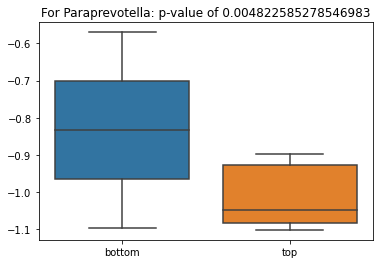

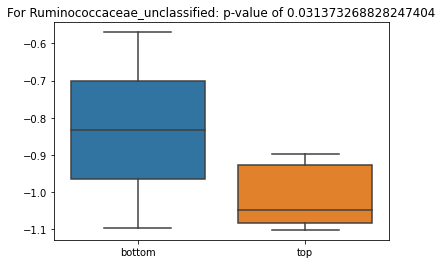

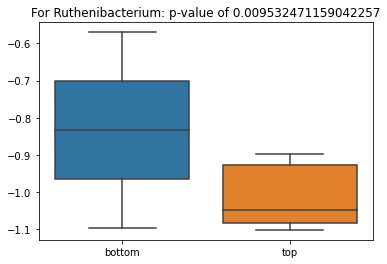

In [224]:
for genus in top_temps_genus.columns.drop('temperature'):
    top_temps_list = np.array(top_temps_genus[genus])
    bottom_temps_list = np.array(bottom_temps_genus[genus])
    p_value = stats.ttest_ind(top_temps_list, bottom_temps_list).pvalue
    if p_value < 0.05:
        plt.figure(genus)
        sns.boxplot(data=plot_df.T, order = ['bottom', 'top'])
        plt.title(f"For {genus}: p-value of {p_value}")

In [220]:
bottom_temps = dataframe_per_species[dataframe_per_species["temperature"] <= 10.7]

In [221]:
top_temps = dataframe_per_species[dataframe_per_species["temperature"] >= 25]

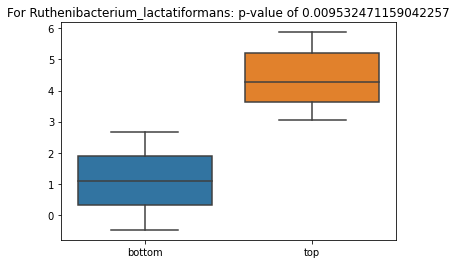

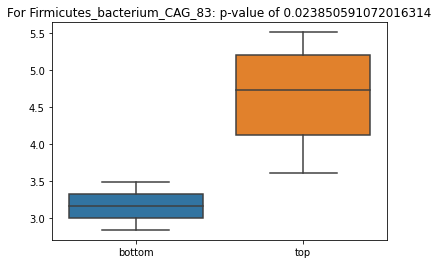

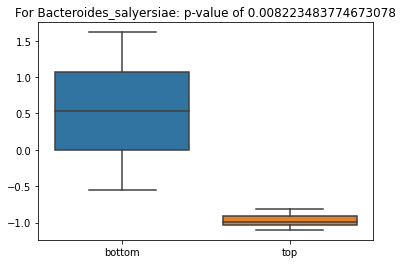

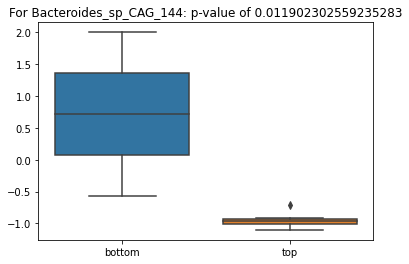

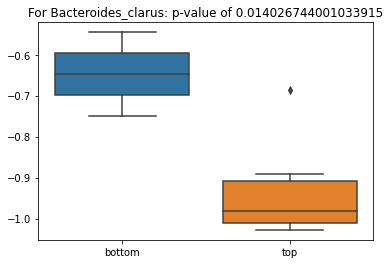

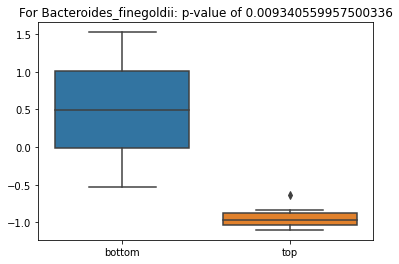

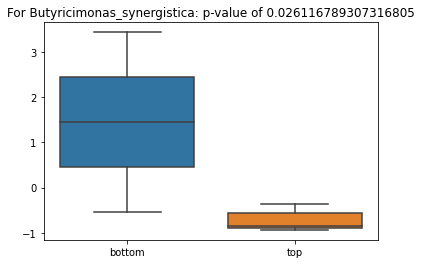

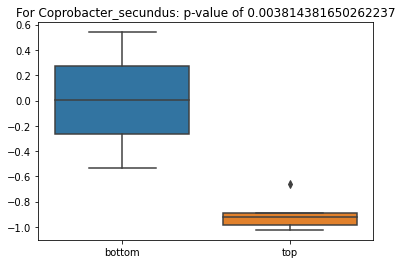

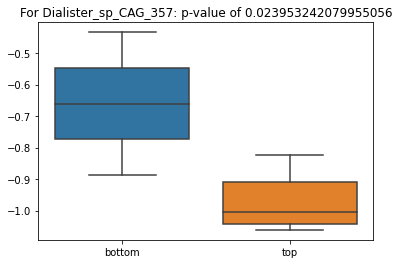

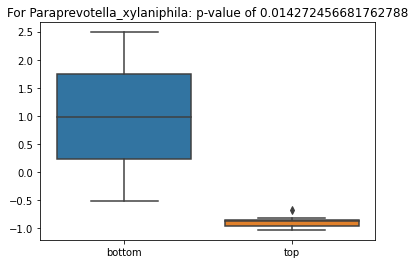

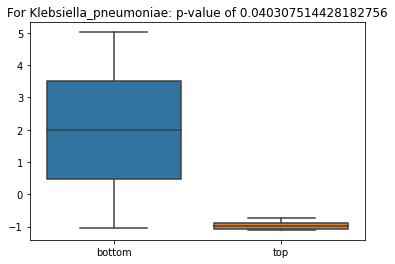

In [223]:
for species in dataframe_per_species.columns.drop('temperature'):
    top_temps_list = np.array(top_temps[species])
    bottom_temps_list = np.array(bottom_temps[species])
    plot_df = pd.DataFrame([top_temps[species], bottom_temps[species]], index = ["bottom", "top"])
    p_value = stats.ttest_ind(top_temps_list, bottom_temps_list).pvalue
    if p_value < 0.05:
        plt.figure(species)
        sns.boxplot(data=plot_df.T)
        plt.title(f"For {species}: p-value of {p_value}")